In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.sparse as sparse
import pickle
import csv
import implicit
import itertools
import copy
plt.style.use('ggplot')
#read_csv()中的路径./指的是项目的根目录(即工作路径)
df = pd.read_csv('./data/model_likes_anon.psv',
                 sep='|', quoting=csv.QUOTE_MINIMAL,
                 quotechar='\\')
df.head()
#获取表中重复记录的条数
print('Duplicated rows: ' + str(df.duplicated().sum()))
print('That\'s weird - let\'s just drop them')
#删除重复的记录
df.drop_duplicates(inplace=True)
df = df[['uid', 'mid']]
df.head()
print df.shape[0]

Duplicated rows: 155
That's weird - let's just drop them
632677


In [2]:
'''
按条件过滤数据
uid_min 过滤出用户查看次数 >=uid_min 的数据
mid_min 过滤出物品被查看次数 >=mid_min 的数据
'''
def threshold_likes(df, uid_min, mid_min):
    #获取有多少用户
    n_users = df.uid.unique().shape[0]
    #获取有多少item
    n_items = df.mid.unique().shape[0]
    #稀疏程度 值越小越稀疏
    sparsity = float(df.shape[0]) / float(n_users*n_items) * 100
    print('Starting likes info')
    print('Number of users: {}'.format(n_users))
    print('Number of models: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    
    done = False
    while not done:
        starting_shape = df.shape[0]
        #按uid分组 得到的数据就是每个用户查看了多少次 其实按我的理解这里应该是uid_counts
        uid_counts = df.groupby('uid').mid.count()
        # 过滤掉用户查看次数小于mid_min的数据 ~：取非
        df = df[~df.uid.isin(uid_counts[uid_counts < uid_min].index.tolist())]
        #按mid分组 得到的数据就是每个item被查看了多少次 其实按我的理解这里应该是mid_counts
        mid_counts = df.groupby('mid').uid.count()
        # 过滤掉item被查看次数小于mid_min的数据
        df = df[~df.mid.isin(mid_counts[mid_counts < mid_min].index.tolist())]
        #循环直到再也不能过滤数据为止
        ending_shape = df.shape[0]
        if starting_shape == ending_shape:
            done = True
    #断言 所以这里的
    assert(df.groupby('uid').mid.count().min() >= uid_min)
    assert(df.groupby('mid').uid.count().min() >= mid_min)
    
    n_users = df.uid.unique().shape[0]
    n_items = df.mid.unique().shape[0]
    sparsity = float(df.shape[0]) / float(n_users*n_items) * 100
    print('Ending likes info')
    print('Number of users: {}'.format(n_users))
    print('Number of models: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    return df

df_lim = threshold_likes(df,5,5)

Starting likes info
Number of users: 62583
Number of models: 28806
Sparsity: 0.035%


Ending likes info
Number of users: 15274
Number of models: 25655
Sparsity: 0.140%


In [3]:
# Create mapping
'''
创建idx -> uid   idx -> item的映射
idx由enumerate生产，从0开始 step为1  依次递增
'''
mid_to_idx = {}
idx_to_mid = {}
for (idx,mid) in enumerate(df_lim.mid.unique().tolist()):
    mid_to_idx[mid] = idx
    idx_to_mid[idx] = mid
    
uid_to_idx = {}
idx_to_uid = {}
for (idx, uid) in enumerate(df_lim.uid.unique().tolist()):
    uid_to_idx[uid] = idx
    idx_to_uid[idx] = uid

In [4]:
def map_ids(row, mapper):
    return mapper[row]
# 获取uid对应的idx，返回成矩阵的形式，也就是numpy.ndarray
I = df_lim.uid.apply(map_ids, args=[uid_to_idx]).as_matrix()
# 获取item对应的idx，返回
J = df_lim.mid.apply(map_ids, args=[mid_to_idx]).as_matrix()
#根据uid的维度构建一个单位矩阵(在这里就是一个一维的向量)
V = np.ones(I.shape[0])
# 按坐标存储稀疏矩阵 I,J为坐标  V是值
likes = sparse.coo_matrix((V, (I, J)), dtype=np.float64)
print likes.shape
# 按行压缩 比如同一个坐标出现了3次1 那么这个位置就是3
likes = likes.tocsr()
print likes.shape

(15274, 25655)
(15274, 25655)


In [5]:
train = likes.copy().tocoo()
print np.int32(np.floor(0.2 * train.shape[0]))
print np.where(np.bincount(train.row) >= 5 * 2)[0]

3054
[    0     1     2 ..., 15265 15266 15267]


In [6]:
'''
切分训练集和测试集
'''
def train_test_split(ratings, split_count, fraction=None):
    """
    Split recommendation data into train and test sets
    
    Params
    ------
    ratings : scipy.sparse matrix
        Interactions between users and items.
    split_count : int
        Number of user-item-interactions per user to move
        from training to test set.
    fractions : float
        Fraction of users to split off some of their
        interactions into test set. If None, then all 
        users are considered.
    """
    # Note: likely not the fastest way to do things below.
    train = ratings.copy().tocoo()
    test = sparse.lil_matrix(train.shape)
    
    if fraction:
        try:
            # 这里就是从8000多个用户中随机挑选出3054个用户 作为测试集
            user_index = np.random.choice(
                # 获取查看次数 >= split_count * 2 的用户ID的index，这里有8000多个用户
                np.where(np.bincount(train.row) >= split_count * 2)[0], 
                replace=False,
                # 总人数的0.2 = 3054
                size=np.int32(np.floor(fraction * train.shape[0]))
            ).tolist()
        except:
            print(('Not enough users with > {} '
                  'interactions for fraction of {}')\
                  .format(2*k, fraction))
            raise
    else:
        user_index = range(train.shape[0])
        
    train = train.tolil()

    for user in user_index:
        test_ratings = np.random.choice(ratings.getrow(user).indices, 
                                        size=split_count, 
                                        replace=False)
        train[user, test_ratings] = 0.
        # These are just 1.0 right now
        test[user, test_ratings] = ratings[user, test_ratings]
   
    # Test and training are truly disjoint
    assert(train.multiply(test).nnz == 0)
    return train.tocsr(), test.tocsr(), user_index
train, test, user_index = train_test_split(likes, 2, fraction=0.2)
print "end"

end


In [7]:
""" Implicit Alternating Least Squares """
import numpy as np
import time
import os
import logging

log = logging.getLogger("implicit")


class ALS(object):

    def __init__(self,
                 num_factors=40,
                 regularization=0.01,
                 alpha=1.0,
                 iterations=15,
                 use_native=True,
                 num_threads=0,
                 dtype=np.float64):
        """
        Class version of alternating least squares implicit matrix factorization

        Args:
            num_factors (int): Number of factors to extract
            regularization (double): Regularization parameter to use
            iterations (int): Number of alternating least squares iterations to
            run
            use_native (bool): Whether or not to use Cython solver
            num_threads (int): Number of threads to run least squares iterations.
            0 means to use all CPU cores.
            dtype (np dtype): Datatype for numpy arrays
        """
        self.num_factors = num_factors
        self.regularization = regularization
        self.alpha = alpha
        self.iterations = iterations
        self.use_native = use_native
        self.num_threads = num_threads
        self.dtype = dtype

    def fit(self, Cui):
        """
        Fit an alternating least squares model on Cui data

        Args:
            Cui (sparse matrix, shape=(num_users, num_items)): Matrix of
            user-item "interactions"
        """

        _check_open_blas()

        users, items = Cui.shape

        self.user_vectors = np.random.normal(size=(users, self.num_factors))\
                                     .astype(self.dtype)

        self.item_vectors = np.random.normal(size=(items, self.num_factors))\
                                     .astype(self.dtype)

        self.solver = implicit.als.least_squares if self.use_native else least_squares

        self.fit_partial(Cui)

    def fit_partial(self, Cui):
        """Continue fitting model"""

        # Scaling
        Cui = Cui.copy()
        Cui.data *= self.alpha
        Cui, Ciu = Cui.tocsr(), Cui.T.tocsr()

        for iteration in range(self.iterations):
            s = time.time()
            self.solver(Cui,
                        self.user_vectors,
                        self.item_vectors,
                        self.regularization,
                        self.num_threads)
            self.solver(Ciu,
                        self.item_vectors,
                        self.user_vectors,
                        self.regularization,
                        self.num_threads)
            log.debug("finished iteration %i in %s", iteration, time.time() - s)

    def predict(self, user, item):
        """Predict for single user and item"""
        return self.user_vectors[user, :].dot(self.item_vectors[item, :].T)

    def predict_for_customers(self,):
        """Recommend products for all customers"""
        return self.user_vectors.dot(self.item_vectors.T)

    def predict_for_items(self, norm=True):
        """Recommend products for all products"""
        pred = self.item_vectors.dot(self.item_vectors.T)
        if norm:
            norms = np.array([np.sqrt(np.diagonal(pred))])
            pred = pred / norms / norms.T
        return pred

def alternating_least_squares(Cui, factors, regularization=0.01,
                              iterations=15, use_native=True, num_threads=0,
                              dtype=np.float64):
    """ factorizes the matrix Cui using an implicit alternating least squares
    algorithm

    Args:
        Cui (csr_matrix): Confidence Matrix
        factors (int): Number of factors to extract
        regularization (double): Regularization parameter to use
        iterations (int): Number of alternating least squares iterations to
        run
        num_threads (int): Number of threads to run least squares iterations.
        0 means to use all CPU cores.

    Returns:
        tuple: A tuple of (row, col) factors
    """
    _check_open_blas()

    users, items = Cui.shape

    X = np.random.rand(users, factors).astype(dtype) * 0.01
    Y = np.random.rand(items, factors).astype(dtype) * 0.01

    Cui, Ciu = Cui.tocsr(), Cui.T.tocsr()

    solver = implicit.als.least_squares if use_native else least_squares

    for iteration in range(iterations):
        s = time.time()
        solver(Cui, X, Y, regularization, num_threads)
        solver(Ciu, Y, X, regularization, num_threads)
        log.debug("finished iteration %i in %s", iteration, time.time() - s)

    return X, Y


def least_squares(Cui, X, Y, regularization, num_threads):
    """ For each user in Cui, calculate factors Xu for them
    using least squares on Y.

    Note: this is at least 10 times slower than the cython version included
    here.
    """
    users, factors = X.shape
    YtY = Y.T.dot(Y)

    for u in range(users):
        # accumulate YtCuY + regularization*I in A
        A = YtY + regularization * np.eye(factors)

        # accumulate YtCuPu in b
        b = np.zeros(factors)

        for i, confidence in nonzeros(Cui, u):
            factor = Y[i]
            A += (confidence - 1) * np.outer(factor, factor)
            b += confidence * factor

        # Xu = (YtCuY + regularization * I)^-1 (YtCuPu)
        X[u] = np.linalg.solve(A, b)


def nonzeros(m, row):
    """ returns the non zeroes of a row in csr_matrix """
    for index in range(m.indptr[row], m.indptr[row+1]):
        yield m.indices[index], m.data[index]


def _check_open_blas():
    """ checks to see if using OpenBlas. If so, warn if the number of threads isn't set to 1
    (causes perf issues) """
    if np.__config__.get_info('openblas_info') and os.environ.get('OPENBLAS_NUM_THREADS') != '1':
        log.warn("OpenBLAS detected. Its highly recommend to set the environment variable "
                 "'export OPENBLAS_NUM_THREADS=1' to disable its internal multithreading")

In [21]:
from sklearn.metrics import mean_squared_error
def calculate_mse(model, ratings, user_index=None):
    preds = model.predict_for_customers()
    if user_index:
        return mean_squared_error(ratings[user_index, :].toarray().ravel(),
                                  preds[user_index, :].ravel())
    
    return mean_squared_error(ratings.toarray().ravel(),
                              preds.ravel())

def precision_at_k(model, ratings, k=5, user_index=None):
    if not user_index:
        user_index = range(ratings.shape[0])
    ratings = ratings.tocsr()
    precisions = []
    # Note: line below may become infeasible for large datasets.
    predictions = model.predict_for_customers()
    for user in user_index:
        # In case of large dataset, compute predictions row-by-row like below
        # predictions = np.array([model.predict(row, i) for i in xrange(ratings.shape[1])])
        top_k = np.argsort(-predictions[user, :])[:k]
        labels = ratings.getrow(user).indices
        precision = float(len(set(top_k) & set(labels))) / float(k)
        precisions.append(precision)
    return np.mean(precisions)  

def print_log(row, header=False, spacing=12):
    top = ''
    middle = ''
    bottom = ''
    for r in row:
        top += '+{}'.format('-'*spacing)
        if isinstance(r, str):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif isinstance(r, int):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif isinstance(r, float):
            middle += '| {0:^{1}.5f} '.format(r, spacing-2)
        bottom += '+{}'.format('='*spacing)
    top += '+'
    middle += '|'
    bottom += '+'
    if header:
        print(top)
        print(middle)
        print(bottom)
    else:
        print(middle)
        print(top)
        
def learning_curve(model, train, test, epochs, k=5, user_index=None):
    if not user_index:
        user_index = range(train.shape[0])
    prev_epoch = 0
    train_precision = []
    train_mse = []
    test_precision = []
    test_mse = []
    
    headers = ['epochs', 'p@k train', 'p@k test',
               'mse train', 'mse test']
    print_log(headers, header=True)
    
    for epoch in epochs:
        model.iterations = epoch - prev_epoch
        if not hasattr(model, 'user_vectors'):
            model.fit(train)
        else:
            model.fit_partial(train)
        train_mse.append(calculate_mse(model, train, user_index))
        train_precision.append(precision_at_k(model, train, k, user_index))
        test_mse.append(calculate_mse(model, test, user_index))
        test_precision.append(precision_at_k(model, test, k, user_index))
        row = [epoch, train_precision[-1], test_precision[-1],
               train_mse[-1], test_mse[-1]]
        print_log(row)
        prev_epoch = epoch
    return model, train_precision, train_mse, test_precision, test_mse

def grid_search_learning_curve(base_model, train, test, param_grid,
                               user_index=None, patk=5, epochs=range(2, 40, 2)):
    """
    "Inspired" (stolen) from sklearn gridsearch
    https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_search.py
    """
    curves = []
    keys, values = zip(*param_grid.items())
    for v in itertools.product(*values):
        params = dict(zip(keys, v))
        this_model = copy.deepcopy(base_model)
        print_line = []
        for k, v in params.items():
            setattr(this_model, k, v)
            print_line.append((k, v))

        print(' | '.join('{}: {}'.format(k, v) for (k, v) in print_line))
        _, train_patk, train_mse, test_patk, test_mse = learning_curve(this_model, train, test,
                                                                epochs, k=patk, user_index=user_index)
        curves.append({'params': params,
                       'patk': {'train': train_patk, 'test': test_patk},
                       'mse': {'train': train_mse, 'test': test_mse}})
    return curves

In [22]:
param_grid = {'num_factors': [10, 20, 40],
              'regularization': [0.0, 1e-1, 1e1],
              'alpha': [1, 10, 50]}

base_model = ALS()

curves = grid_search_learning_curve(base_model, train, test,
                                    param_grid,
                                    user_index=user_index,
                                    patk=5)

alpha: 1 | regularization: 0.0 | num_factors: 10
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+


|     2      |  0.11893   |  0.01153   |  0.00121   |  0.00032   |
+------------+------------+------------+------------+------------+


|     4      |  0.11958   |  0.01336   |  0.00119   |  0.00035   |
+------------+------------+------------+------------+------------+


|     6      |  0.11978   |  0.01297   |  0.00118   |  0.00035   |
+------------+------------+------------+------------+------------+


|     8      |  0.12037   |  0.01264   |  0.00118   |  0.00036   |
+------------+------------+------------+------------+------------+


|     10     |  0.12010   |  0.01284   |  0.00118   |  0.00036   |
+------------+------------+------------+------------+------------+


|     12     |  0.11893   |  0.01231   |  0.00118   |  0.00036   |
+------------+------------+------------+------------+------------+


|     14     |  0.11834   |  0.01238   |  0.00118   |  0.00036   |
+------------+------------+------------+------------+------------+


|     16     |  0.11742   |  0.01244   |  0.00118   |  0.00036   |
+------------+------------+------------+------------+------------+


|     18     |  0.11663   |  0.01218   |  0.00118   |  0.00036   |
+------------+------------+------------+------------+------------+


|     20     |  0.11670   |  0.01212   |  0.00118   |  0.00036   |
+------------+------------+------------+------------+------------+


|     22     |  0.11624   |  0.01218   |  0.00118   |  0.00036   |
+------------+------------+------------+------------+------------+


|     24     |  0.11591   |  0.01218   |  0.00118   |  0.00036   |
+------------+------------+------------+------------+------------+


|     26     |  0.11591   |  0.01225   |  0.00118   |  0.00036   |
+------------+------------+------------+------------+------------+


|     28     |  0.11591   |  0.01218   |  0.00118   |  0.00036   |
+------------+------------+------------+------------+------------+


|     30     |  0.11611   |  0.01218   |  0.00118   |  0.00036   |
+------------+------------+------------+------------+------------+


|     32     |  0.11598   |  0.01218   |  0.00118   |  0.00036   |
+------------+------------+------------+------------+------------+


|     34     |  0.11565   |  0.01218   |  0.00118   |  0.00036   |
+------------+------------+------------+------------+------------+


|     36     |  0.11559   |  0.01218   |  0.00118   |  0.00036   |
+------------+------------+------------+------------+------------+


|     38     |  0.11552   |  0.01225   |  0.00118   |  0.00036   |
+------------+------------+------------+------------+------------+
alpha: 1 | regularization: 0.0 | num_factors: 20
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+


|     2      |  0.17917   |  0.01356   |  0.00116   |  0.00038   |
+------------+------------+------------+------------+------------+


|     4      |  0.16791   |  0.01546   |  0.00114   |  0.00040   |
+------------+------------+------------+------------+------------+


|     6      |  0.16509   |  0.01526   |  0.00114   |  0.00040   |
+------------+------------+------------+------------+------------+


|     8      |  0.16385   |  0.01539   |  0.00113   |  0.00040   |
+------------+------------+------------+------------+------------+


|     10     |  0.16516   |  0.01565   |  0.00113   |  0.00040   |
+------------+------------+------------+------------+------------+


|     12     |  0.16555   |  0.01532   |  0.00113   |  0.00040   |
+------------+------------+------------+------------+------------+


|     14     |  0.16496   |  0.01552   |  0.00114   |  0.00040   |
+------------+------------+------------+------------+------------+


|     16     |  0.16595   |  0.01552   |  0.00114   |  0.00040   |
+------------+------------+------------+------------+------------+


|     18     |  0.16627   |  0.01552   |  0.00114   |  0.00040   |
+------------+------------+------------+------------+------------+


|     20     |  0.16686   |  0.01546   |  0.00114   |  0.00040   |
+------------+------------+------------+------------+------------+


|     22     |  0.16706   |  0.01546   |  0.00114   |  0.00040   |
+------------+------------+------------+------------+------------+


|     24     |  0.16719   |  0.01559   |  0.00114   |  0.00040   |
+------------+------------+------------+------------+------------+


|     26     |  0.16693   |  0.01559   |  0.00114   |  0.00040   |
+------------+------------+------------+------------+------------+


|     28     |  0.16706   |  0.01552   |  0.00114   |  0.00040   |
+------------+------------+------------+------------+------------+


|     30     |  0.16739   |  0.01552   |  0.00114   |  0.00040   |
+------------+------------+------------+------------+------------+


|     32     |  0.16739   |  0.01552   |  0.00114   |  0.00040   |
+------------+------------+------------+------------+------------+


|     34     |  0.16785   |  0.01546   |  0.00114   |  0.00040   |
+------------+------------+------------+------------+------------+


|     36     |  0.16785   |  0.01539   |  0.00114   |  0.00040   |
+------------+------------+------------+------------+------------+


|     38     |  0.16785   |  0.01532   |  0.00114   |  0.00040   |
+------------+------------+------------+------------+------------+
alpha: 1 | regularization: 0.0 | num_factors: 40
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+


|     2      |  0.25377   |  0.01310   |  0.00109   |  0.00044   |
+------------+------------+------------+------------+------------+


|     4      |  0.24741   |  0.01703   |  0.00106   |  0.00048   |
+------------+------------+------------+------------+------------+


|     6      |  0.24506   |  0.01663   |  0.00105   |  0.00049   |
+------------+------------+------------+------------+------------+


|     8      |  0.24381   |  0.01690   |  0.00105   |  0.00049   |
+------------+------------+------------+------------+------------+


|     10     |  0.24303   |  0.01703   |  0.00105   |  0.00049   |
+------------+------------+------------+------------+------------+


|     12     |  0.24257   |  0.01709   |  0.00105   |  0.00049   |
+------------+------------+------------+------------+------------+


|     14     |  0.24185   |  0.01722   |  0.00105   |  0.00049   |
+------------+------------+------------+------------+------------+


|     16     |  0.24158   |  0.01722   |  0.00105   |  0.00049   |
+------------+------------+------------+------------+------------+


|     18     |  0.24145   |  0.01742   |  0.00105   |  0.00049   |
+------------+------------+------------+------------+------------+


|     20     |  0.24067   |  0.01749   |  0.00105   |  0.00049   |
+------------+------------+------------+------------+------------+


|     22     |  0.24093   |  0.01755   |  0.00105   |  0.00049   |
+------------+------------+------------+------------+------------+


|     24     |  0.24067   |  0.01755   |  0.00105   |  0.00049   |
+------------+------------+------------+------------+------------+


|     26     |  0.24034   |  0.01749   |  0.00105   |  0.00049   |
+------------+------------+------------+------------+------------+


|     28     |  0.23982   |  0.01768   |  0.00105   |  0.00049   |
+------------+------------+------------+------------+------------+


|     30     |  0.23975   |  0.01775   |  0.00105   |  0.00049   |
+------------+------------+------------+------------+------------+


|     32     |  0.23929   |  0.01781   |  0.00105   |  0.00049   |
+------------+------------+------------+------------+------------+


|     34     |  0.23969   |  0.01788   |  0.00105   |  0.00049   |
+------------+------------+------------+------------+------------+


|     36     |  0.23923   |  0.01781   |  0.00105   |  0.00049   |
+------------+------------+------------+------------+------------+


|     38     |  0.23955   |  0.01781   |  0.00105   |  0.00049   |
+------------+------------+------------+------------+------------+
alpha: 1 | regularization: 0.1 | num_factors: 10
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+


|     2      |  0.12502   |  0.01107   |  0.00121   |  0.00032   |
+------------+------------+------------+------------+------------+


|     4      |  0.11775   |  0.01244   |  0.00119   |  0.00035   |
+------------+------------+------------+------------+------------+


|     6      |  0.11572   |  0.01297   |  0.00119   |  0.00035   |
+------------+------------+------------+------------+------------+


|     8      |  0.11506   |  0.01264   |  0.00119   |  0.00035   |
+------------+------------+------------+------------+------------+


|     10     |  0.11506   |  0.01212   |  0.00119   |  0.00035   |
+------------+------------+------------+------------+------------+


|     12     |  0.11500   |  0.01185   |  0.00119   |  0.00035   |
+------------+------------+------------+------------+------------+


|     14     |  0.11480   |  0.01205   |  0.00119   |  0.00035   |
+------------+------------+------------+------------+------------+


|     16     |  0.11506   |  0.01185   |  0.00119   |  0.00035   |
+------------+------------+------------+------------+------------+


|     18     |  0.11401   |  0.01192   |  0.00119   |  0.00035   |
+------------+------------+------------+------------+------------+


|     20     |  0.11408   |  0.01185   |  0.00118   |  0.00035   |
+------------+------------+------------+------------+------------+


|     22     |  0.11460   |  0.01198   |  0.00118   |  0.00035   |
+------------+------------+------------+------------+------------+


|     24     |  0.11480   |  0.01205   |  0.00118   |  0.00035   |
+------------+------------+------------+------------+------------+


|     26     |  0.11460   |  0.01212   |  0.00118   |  0.00035   |
+------------+------------+------------+------------+------------+


|     28     |  0.11454   |  0.01218   |  0.00118   |  0.00035   |
+------------+------------+------------+------------+------------+


|     30     |  0.11434   |  0.01225   |  0.00118   |  0.00035   |
+------------+------------+------------+------------+------------+


|     32     |  0.11441   |  0.01218   |  0.00118   |  0.00035   |
+------------+------------+------------+------------+------------+


|     34     |  0.11454   |  0.01218   |  0.00118   |  0.00035   |
+------------+------------+------------+------------+------------+


|     36     |  0.11473   |  0.01218   |  0.00118   |  0.00035   |
+------------+------------+------------+------------+------------+


|     38     |  0.11467   |  0.01218   |  0.00118   |  0.00035   |
+------------+------------+------------+------------+------------+
alpha: 1 | regularization: 0.1 | num_factors: 20
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+


|     2      |  0.17544   |  0.01408   |  0.00116   |  0.00037   |
+------------+------------+------------+------------+------------+


|     4      |  0.16765   |  0.01585   |  0.00114   |  0.00040   |
+------------+------------+------------+------------+------------+


|     6      |  0.16837   |  0.01565   |  0.00114   |  0.00040   |
+------------+------------+------------+------------+------------+


|     8      |  0.16935   |  0.01598   |  0.00114   |  0.00040   |
+------------+------------+------------+------------+------------+


|     10     |  0.17040   |  0.01650   |  0.00114   |  0.00040   |
+------------+------------+------------+------------+------------+


|     12     |  0.16961   |  0.01624   |  0.00114   |  0.00040   |
+------------+------------+------------+------------+------------+


|     14     |  0.17001   |  0.01624   |  0.00114   |  0.00040   |
+------------+------------+------------+------------+------------+


|     16     |  0.16889   |  0.01650   |  0.00114   |  0.00040   |
+------------+------------+------------+------------+------------+


|     18     |  0.16916   |  0.01663   |  0.00114   |  0.00040   |
+------------+------------+------------+------------+------------+


|     20     |  0.16974   |  0.01637   |  0.00114   |  0.00040   |
+------------+------------+------------+------------+------------+


|     22     |  0.16988   |  0.01637   |  0.00114   |  0.00040   |
+------------+------------+------------+------------+------------+


|     24     |  0.16961   |  0.01618   |  0.00114   |  0.00040   |
+------------+------------+------------+------------+------------+


|     26     |  0.16935   |  0.01644   |  0.00114   |  0.00040   |
+------------+------------+------------+------------+------------+


|     28     |  0.16916   |  0.01637   |  0.00113   |  0.00040   |
+------------+------------+------------+------------+------------+


|     30     |  0.16909   |  0.01624   |  0.00113   |  0.00040   |
+------------+------------+------------+------------+------------+


|     32     |  0.16870   |  0.01591   |  0.00113   |  0.00040   |
+------------+------------+------------+------------+------------+


|     34     |  0.16830   |  0.01585   |  0.00113   |  0.00040   |
+------------+------------+------------+------------+------------+


|     36     |  0.16804   |  0.01591   |  0.00113   |  0.00040   |
+------------+------------+------------+------------+------------+


|     38     |  0.16811   |  0.01604   |  0.00113   |  0.00040   |
+------------+------------+------------+------------+------------+
alpha: 1 | regularization: 0.1 | num_factors: 40
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+


|     2      |  0.25547   |  0.01526   |  0.00109   |  0.00043   |
+------------+------------+------------+------------+------------+


|     4      |  0.25010   |  0.01755   |  0.00106   |  0.00047   |
+------------+------------+------------+------------+------------+


|     6      |  0.24695   |  0.01834   |  0.00106   |  0.00048   |
+------------+------------+------------+------------+------------+


|     8      |  0.24407   |  0.01768   |  0.00105   |  0.00048   |
+------------+------------+------------+------------+------------+


|     10     |  0.24361   |  0.01781   |  0.00105   |  0.00048   |
+------------+------------+------------+------------+------------+


|     12     |  0.24381   |  0.01762   |  0.00105   |  0.00048   |
+------------+------------+------------+------------+------------+


|     14     |  0.24204   |  0.01801   |  0.00105   |  0.00048   |
+------------+------------+------------+------------+------------+


|     16     |  0.24237   |  0.01801   |  0.00105   |  0.00048   |
+------------+------------+------------+------------+------------+


|     18     |  0.24224   |  0.01821   |  0.00105   |  0.00049   |
+------------+------------+------------+------------+------------+


|     20     |  0.24191   |  0.01827   |  0.00105   |  0.00049   |
+------------+------------+------------+------------+------------+


|     22     |  0.24165   |  0.01821   |  0.00105   |  0.00049   |
+------------+------------+------------+------------+------------+


|     24     |  0.24211   |  0.01827   |  0.00105   |  0.00049   |
+------------+------------+------------+------------+------------+


|     26     |  0.24119   |  0.01821   |  0.00105   |  0.00049   |
+------------+------------+------------+------------+------------+


|     28     |  0.24100   |  0.01814   |  0.00105   |  0.00049   |
+------------+------------+------------+------------+------------+


|     30     |  0.24106   |  0.01807   |  0.00105   |  0.00049   |
+------------+------------+------------+------------+------------+


|     32     |  0.24093   |  0.01788   |  0.00105   |  0.00049   |
+------------+------------+------------+------------+------------+


|     34     |  0.24113   |  0.01788   |  0.00105   |  0.00049   |
+------------+------------+------------+------------+------------+


|     36     |  0.24073   |  0.01788   |  0.00105   |  0.00049   |
+------------+------------+------------+------------+------------+


|     38     |  0.24086   |  0.01781   |  0.00105   |  0.00049   |
+------------+------------+------------+------------+------------+
alpha: 1 | regularization: 10.0 | num_factors: 10
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+


|     2      |  0.06208   |  0.00681   |  0.00133   |  0.00018   |
+------------+------------+------------+------------+------------+


|     4      |  0.12436   |  0.01336   |  0.00119   |  0.00029   |
+------------+------------+------------+------------+------------+


|     6      |  0.12220   |  0.01362   |  0.00119   |  0.00030   |
+------------+------------+------------+------------+------------+


|     8      |  0.11906   |  0.01329   |  0.00119   |  0.00030   |
+------------+------------+------------+------------+------------+


|     10     |  0.11611   |  0.01212   |  0.00119   |  0.00030   |
+------------+------------+------------+------------+------------+


|     12     |  0.11428   |  0.01205   |  0.00119   |  0.00030   |
+------------+------------+------------+------------+------------+


|     14     |  0.11395   |  0.01166   |  0.00119   |  0.00030   |
+------------+------------+------------+------------+------------+


|     16     |  0.11316   |  0.01198   |  0.00119   |  0.00030   |
+------------+------------+------------+------------+------------+


|     18     |  0.11244   |  0.01205   |  0.00119   |  0.00030   |
+------------+------------+------------+------------+------------+


|     20     |  0.11244   |  0.01212   |  0.00119   |  0.00030   |
+------------+------------+------------+------------+------------+


|     22     |  0.11198   |  0.01212   |  0.00119   |  0.00030   |
+------------+------------+------------+------------+------------+


|     24     |  0.11218   |  0.01205   |  0.00119   |  0.00030   |
+------------+------------+------------+------------+------------+


|     26     |  0.11257   |  0.01218   |  0.00119   |  0.00030   |
+------------+------------+------------+------------+------------+


|     28     |  0.11264   |  0.01225   |  0.00119   |  0.00030   |
+------------+------------+------------+------------+------------+


|     30     |  0.11251   |  0.01225   |  0.00119   |  0.00030   |
+------------+------------+------------+------------+------------+


|     32     |  0.11303   |  0.01225   |  0.00119   |  0.00030   |
+------------+------------+------------+------------+------------+


|     34     |  0.11303   |  0.01225   |  0.00119   |  0.00030   |
+------------+------------+------------+------------+------------+


|     36     |  0.11323   |  0.01231   |  0.00119   |  0.00030   |
+------------+------------+------------+------------+------------+


|     38     |  0.11336   |  0.01231   |  0.00119   |  0.00030   |
+------------+------------+------------+------------+------------+
alpha: 1 | regularization: 10.0 | num_factors: 20
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+


|     2      |  0.06202   |  0.00753   |  0.00132   |  0.00018   |
+------------+------------+------------+------------+------------+


|     4      |  0.16536   |  0.01618   |  0.00114   |  0.00033   |
+------------+------------+------------+------------+------------+


|     6      |  0.16248   |  0.01604   |  0.00114   |  0.00033   |
+------------+------------+------------+------------+------------+


|     8      |  0.16320   |  0.01618   |  0.00114   |  0.00033   |
+------------+------------+------------+------------+------------+


|     10     |  0.16287   |  0.01598   |  0.00114   |  0.00033   |
+------------+------------+------------+------------+------------+


|     12     |  0.16398   |  0.01644   |  0.00114   |  0.00033   |
+------------+------------+------------+------------+------------+


|     14     |  0.16457   |  0.01637   |  0.00114   |  0.00033   |
+------------+------------+------------+------------+------------+


|     16     |  0.16529   |  0.01611   |  0.00114   |  0.00033   |
+------------+------------+------------+------------+------------+


|     18     |  0.16549   |  0.01611   |  0.00114   |  0.00033   |
+------------+------------+------------+------------+------------+


|     20     |  0.16562   |  0.01604   |  0.00114   |  0.00033   |
+------------+------------+------------+------------+------------+


|     22     |  0.16529   |  0.01604   |  0.00114   |  0.00033   |
+------------+------------+------------+------------+------------+


|     24     |  0.16542   |  0.01598   |  0.00114   |  0.00033   |
+------------+------------+------------+------------+------------+


|     26     |  0.16523   |  0.01598   |  0.00114   |  0.00033   |
+------------+------------+------------+------------+------------+


|     28     |  0.16490   |  0.01591   |  0.00114   |  0.00033   |
+------------+------------+------------+------------+------------+


|     30     |  0.16490   |  0.01598   |  0.00114   |  0.00033   |
+------------+------------+------------+------------+------------+


|     32     |  0.16464   |  0.01598   |  0.00114   |  0.00033   |
+------------+------------+------------+------------+------------+


|     34     |  0.16451   |  0.01598   |  0.00114   |  0.00033   |
+------------+------------+------------+------------+------------+


|     36     |  0.16431   |  0.01598   |  0.00114   |  0.00033   |
+------------+------------+------------+------------+------------+


|     38     |  0.16424   |  0.01598   |  0.00114   |  0.00033   |
+------------+------------+------------+------------+------------+
alpha: 1 | regularization: 10.0 | num_factors: 40
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+


|     2      |  0.07014   |  0.00812   |  0.00131   |  0.00020   |
+------------+------------+------------+------------+------------+


|     4      |  0.24145   |  0.01775   |  0.00107   |  0.00037   |
+------------+------------+------------+------------+------------+


|     6      |  0.23759   |  0.01788   |  0.00107   |  0.00037   |
+------------+------------+------------+------------+------------+


|     8      |  0.23694   |  0.01762   |  0.00106   |  0.00037   |
+------------+------------+------------+------------+------------+


|     10     |  0.23635   |  0.01788   |  0.00106   |  0.00037   |
+------------+------------+------------+------------+------------+


|     12     |  0.23595   |  0.01781   |  0.00106   |  0.00037   |
+------------+------------+------------+------------+------------+


|     14     |  0.23608   |  0.01775   |  0.00106   |  0.00037   |
+------------+------------+------------+------------+------------+


|     16     |  0.23608   |  0.01775   |  0.00106   |  0.00037   |
+------------+------------+------------+------------+------------+


|     18     |  0.23615   |  0.01775   |  0.00106   |  0.00037   |
+------------+------------+------------+------------+------------+


|     20     |  0.23635   |  0.01794   |  0.00106   |  0.00037   |
+------------+------------+------------+------------+------------+


|     22     |  0.23680   |  0.01788   |  0.00106   |  0.00037   |
+------------+------------+------------+------------+------------+


|     24     |  0.23746   |  0.01788   |  0.00106   |  0.00037   |
+------------+------------+------------+------------+------------+


|     26     |  0.23733   |  0.01788   |  0.00106   |  0.00037   |
+------------+------------+------------+------------+------------+


|     28     |  0.23713   |  0.01775   |  0.00106   |  0.00037   |
+------------+------------+------------+------------+------------+


|     30     |  0.23746   |  0.01768   |  0.00106   |  0.00037   |
+------------+------------+------------+------------+------------+


|     32     |  0.23739   |  0.01768   |  0.00106   |  0.00037   |
+------------+------------+------------+------------+------------+


|     34     |  0.23772   |  0.01768   |  0.00106   |  0.00037   |
+------------+------------+------------+------------+------------+


|     36     |  0.23759   |  0.01762   |  0.00106   |  0.00037   |
+------------+------------+------------+------------+------------+


|     38     |  0.23739   |  0.01762   |  0.00106   |  0.00037   |
+------------+------------+------------+------------+------------+
alpha: 10 | regularization: 0.0 | num_factors: 10
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+


|     2      |  0.14578   |  0.01146   |  0.00254   |  0.00220   |
+------------+------------+------------+------------+------------+


|     4      |  0.14021   |  0.01657   |  0.00259   |  0.00234   |
+------------+------------+------------+------------+------------+


|     6      |  0.14185   |  0.01755   |  0.00261   |  0.00237   |
+------------+------------+------------+------------+------------+


|     8      |  0.14316   |  0.01735   |  0.00261   |  0.00238   |
+------------+------------+------------+------------+------------+


|     10     |  0.14322   |  0.01650   |  0.00261   |  0.00238   |
+------------+------------+------------+------------+------------+


|     12     |  0.14329   |  0.01637   |  0.00261   |  0.00238   |
+------------+------------+------------+------------+------------+


|     14     |  0.14185   |  0.01591   |  0.00261   |  0.00238   |
+------------+------------+------------+------------+------------+


|     16     |  0.14093   |  0.01585   |  0.00261   |  0.00238   |
+------------+------------+------------+------------+------------+


|     18     |  0.14080   |  0.01598   |  0.00261   |  0.00238   |
+------------+------------+------------+------------+------------+


|     20     |  0.14080   |  0.01591   |  0.00261   |  0.00238   |
+------------+------------+------------+------------+------------+


|     22     |  0.13995   |  0.01591   |  0.00260   |  0.00238   |
+------------+------------+------------+------------+------------+


|     24     |  0.13969   |  0.01604   |  0.00260   |  0.00238   |
+------------+------------+------------+------------+------------+


|     26     |  0.13942   |  0.01611   |  0.00260   |  0.00238   |
+------------+------------+------------+------------+------------+


|     28     |  0.13897   |  0.01604   |  0.00260   |  0.00238   |
+------------+------------+------------+------------+------------+


|     30     |  0.13870   |  0.01604   |  0.00260   |  0.00238   |
+------------+------------+------------+------------+------------+


|     32     |  0.13851   |  0.01585   |  0.00260   |  0.00238   |
+------------+------------+------------+------------+------------+


|     34     |  0.13864   |  0.01585   |  0.00260   |  0.00238   |
+------------+------------+------------+------------+------------+


|     36     |  0.13851   |  0.01591   |  0.00260   |  0.00238   |
+------------+------------+------------+------------+------------+


|     38     |  0.13851   |  0.01585   |  0.00260   |  0.00238   |
+------------+------------+------------+------------+------------+
alpha: 10 | regularization: 0.0 | num_factors: 20
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+


|     2      |  0.23091   |  0.01493   |  0.00258   |  0.00239   |
+------------+------------+------------+------------+------------+


|     4      |  0.20904   |  0.02083   |  0.00260   |  0.00250   |
+------------+------------+------------+------------+------------+


|     6      |  0.20838   |  0.02128   |  0.00260   |  0.00252   |
+------------+------------+------------+------------+------------+


|     8      |  0.20832   |  0.02161   |  0.00260   |  0.00252   |
+------------+------------+------------+------------+------------+


|     10     |  0.21002   |  0.02141   |  0.00260   |  0.00252   |
+------------+------------+------------+------------+------------+


|     12     |  0.20963   |  0.02128   |  0.00260   |  0.00252   |
+------------+------------+------------+------------+------------+


|     14     |  0.20864   |  0.02155   |  0.00260   |  0.00252   |
+------------+------------+------------+------------+------------+


|     16     |  0.20773   |  0.02168   |  0.00261   |  0.00252   |
+------------+------------+------------+------------+------------+


|     18     |  0.20753   |  0.02187   |  0.00261   |  0.00252   |
+------------+------------+------------+------------+------------+


|     20     |  0.20602   |  0.02135   |  0.00261   |  0.00252   |
+------------+------------+------------+------------+------------+


|     22     |  0.20537   |  0.02128   |  0.00260   |  0.00253   |
+------------+------------+------------+------------+------------+


|     24     |  0.20517   |  0.02122   |  0.00260   |  0.00253   |
+------------+------------+------------+------------+------------+


|     26     |  0.20524   |  0.02115   |  0.00260   |  0.00253   |
+------------+------------+------------+------------+------------+


|     28     |  0.20478   |  0.02096   |  0.00260   |  0.00253   |
+------------+------------+------------+------------+------------+


|     30     |  0.20530   |  0.02076   |  0.00260   |  0.00253   |
+------------+------------+------------+------------+------------+


|     32     |  0.20530   |  0.02083   |  0.00260   |  0.00253   |
+------------+------------+------------+------------+------------+


|     34     |  0.20629   |  0.02083   |  0.00260   |  0.00253   |
+------------+------------+------------+------------+------------+


|     36     |  0.20661   |  0.02076   |  0.00260   |  0.00253   |
+------------+------------+------------+------------+------------+


|     38     |  0.20714   |  0.02076   |  0.00260   |  0.00253   |
+------------+------------+------------+------------+------------+
alpha: 10 | regularization: 0.0 | num_factors: 40
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+


|     2      |  0.32705   |  0.01749   |  0.00256   |  0.00257   |
+------------+------------+------------+------------+------------+


|     4      |  0.30825   |  0.02187   |  0.00256   |  0.00264   |
+------------+------------+------------+------------+------------+


|     6      |  0.30255   |  0.02128   |  0.00255   |  0.00265   |
+------------+------------+------------+------------+------------+


|     8      |  0.30131   |  0.02135   |  0.00255   |  0.00265   |
+------------+------------+------------+------------+------------+


|     10     |  0.30118   |  0.02174   |  0.00255   |  0.00265   |
+------------+------------+------------+------------+------------+


|     12     |  0.29895   |  0.02220   |  0.00255   |  0.00265   |
+------------+------------+------------+------------+------------+


|     14     |  0.29836   |  0.02233   |  0.00255   |  0.00265   |
+------------+------------+------------+------------+------------+


|     16     |  0.29686   |  0.02266   |  0.00255   |  0.00265   |
+------------+------------+------------+------------+------------+


|     18     |  0.29679   |  0.02325   |  0.00255   |  0.00265   |
+------------+------------+------------+------------+------------+


|     20     |  0.29666   |  0.02344   |  0.00255   |  0.00265   |
+------------+------------+------------+------------+------------+


|     22     |  0.29633   |  0.02344   |  0.00255   |  0.00265   |
+------------+------------+------------+------------+------------+


|     24     |  0.29731   |  0.02331   |  0.00255   |  0.00265   |
+------------+------------+------------+------------+------------+


|     26     |  0.29771   |  0.02318   |  0.00255   |  0.00266   |
+------------+------------+------------+------------+------------+


|     28     |  0.29790   |  0.02318   |  0.00255   |  0.00266   |
+------------+------------+------------+------------+------------+


|     30     |  0.29797   |  0.02338   |  0.00255   |  0.00266   |
+------------+------------+------------+------------+------------+


|     32     |  0.29830   |  0.02325   |  0.00255   |  0.00266   |
+------------+------------+------------+------------+------------+


|     34     |  0.29817   |  0.02344   |  0.00255   |  0.00266   |
+------------+------------+------------+------------+------------+


|     36     |  0.29836   |  0.02331   |  0.00255   |  0.00266   |
+------------+------------+------------+------------+------------+


|     38     |  0.29876   |  0.02312   |  0.00255   |  0.00266   |
+------------+------------+------------+------------+------------+
alpha: 10 | regularization: 0.1 | num_factors: 10
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+


|     2      |  0.15259   |  0.01231   |  0.00230   |  0.00187   |
+------------+------------+------------+------------+------------+


|     4      |  0.14361   |  0.01552   |  0.00239   |  0.00208   |
+------------+------------+------------+------------+------------+


|     6      |  0.14617   |  0.01578   |  0.00243   |  0.00215   |
+------------+------------+------------+------------+------------+


|     8      |  0.14565   |  0.01572   |  0.00246   |  0.00219   |
+------------+------------+------------+------------+------------+


|     10     |  0.14322   |  0.01618   |  0.00248   |  0.00222   |
+------------+------------+------------+------------+------------+


|     12     |  0.14257   |  0.01604   |  0.00249   |  0.00223   |
+------------+------------+------------+------------+------------+


|     14     |  0.14139   |  0.01618   |  0.00250   |  0.00225   |
+------------+------------+------------+------------+------------+


|     16     |  0.14152   |  0.01611   |  0.00251   |  0.00226   |
+------------+------------+------------+------------+------------+


|     18     |  0.14100   |  0.01611   |  0.00252   |  0.00227   |
+------------+------------+------------+------------+------------+


|     20     |  0.14021   |  0.01598   |  0.00253   |  0.00228   |
+------------+------------+------------+------------+------------+


|     22     |  0.14001   |  0.01598   |  0.00253   |  0.00229   |
+------------+------------+------------+------------+------------+


|     24     |  0.13969   |  0.01591   |  0.00254   |  0.00229   |
+------------+------------+------------+------------+------------+


|     26     |  0.13923   |  0.01598   |  0.00254   |  0.00230   |
+------------+------------+------------+------------+------------+


|     28     |  0.13923   |  0.01598   |  0.00255   |  0.00230   |
+------------+------------+------------+------------+------------+


|     30     |  0.13890   |  0.01611   |  0.00255   |  0.00231   |
+------------+------------+------------+------------+------------+


|     32     |  0.13883   |  0.01611   |  0.00255   |  0.00231   |
+------------+------------+------------+------------+------------+


|     34     |  0.13877   |  0.01611   |  0.00256   |  0.00231   |
+------------+------------+------------+------------+------------+


|     36     |  0.13870   |  0.01611   |  0.00256   |  0.00232   |
+------------+------------+------------+------------+------------+


|     38     |  0.13864   |  0.01611   |  0.00256   |  0.00232   |
+------------+------------+------------+------------+------------+
alpha: 10 | regularization: 0.1 | num_factors: 20
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+


|     2      |  0.21866   |  0.01624   |  0.00215   |  0.00183   |
+------------+------------+------------+------------+------------+


|     4      |  0.21225   |  0.02069   |  0.00231   |  0.00212   |
+------------+------------+------------+------------+------------+


|     6      |  0.21100   |  0.02089   |  0.00238   |  0.00222   |
+------------+------------+------------+------------+------------+


|     8      |  0.20976   |  0.02069   |  0.00242   |  0.00228   |
+------------+------------+------------+------------+------------+


|     10     |  0.20936   |  0.02030   |  0.00245   |  0.00232   |
+------------+------------+------------+------------+------------+


|     12     |  0.21048   |  0.02017   |  0.00247   |  0.00235   |
+------------+------------+------------+------------+------------+


|     14     |  0.20976   |  0.01991   |  0.00249   |  0.00237   |
+------------+------------+------------+------------+------------+


|     16     |  0.20851   |  0.01991   |  0.00250   |  0.00239   |
+------------+------------+------------+------------+------------+


|     18     |  0.20779   |  0.01991   |  0.00251   |  0.00240   |
+------------+------------+------------+------------+------------+


|     20     |  0.20740   |  0.01984   |  0.00252   |  0.00241   |
+------------+------------+------------+------------+------------+


|     22     |  0.20753   |  0.02017   |  0.00252   |  0.00242   |
+------------+------------+------------+------------+------------+


|     24     |  0.20786   |  0.02024   |  0.00253   |  0.00243   |
+------------+------------+------------+------------+------------+


|     26     |  0.20733   |  0.02030   |  0.00254   |  0.00244   |
+------------+------------+------------+------------+------------+


|     28     |  0.20740   |  0.02024   |  0.00254   |  0.00244   |
+------------+------------+------------+------------+------------+


|     30     |  0.20799   |  0.02030   |  0.00254   |  0.00245   |
+------------+------------+------------+------------+------------+


|     32     |  0.20812   |  0.02017   |  0.00255   |  0.00245   |
+------------+------------+------------+------------+------------+


|     34     |  0.20851   |  0.02043   |  0.00255   |  0.00246   |
+------------+------------+------------+------------+------------+


|     36     |  0.20753   |  0.02043   |  0.00255   |  0.00246   |
+------------+------------+------------+------------+------------+


|     38     |  0.20760   |  0.02050   |  0.00256   |  0.00246   |
+------------+------------+------------+------------+------------+
alpha: 10 | regularization: 0.1 | num_factors: 40
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+


|     2      |  0.32069   |  0.01762   |  0.00211   |  0.00194   |
+------------+------------+------------+------------+------------+


|     4      |  0.30714   |  0.02187   |  0.00225   |  0.00221   |
+------------+------------+------------+------------+------------+


|     6      |  0.30399   |  0.02227   |  0.00232   |  0.00233   |
+------------+------------+------------+------------+------------+


|     8      |  0.30164   |  0.02272   |  0.00236   |  0.00239   |
+------------+------------+------------+------------+------------+


|     10     |  0.30124   |  0.02266   |  0.00240   |  0.00244   |
+------------+------------+------------+------------+------------+


|     12     |  0.30046   |  0.02233   |  0.00242   |  0.00247   |
+------------+------------+------------+------------+------------+


|     14     |  0.30111   |  0.02266   |  0.00244   |  0.00250   |
+------------+------------+------------+------------+------------+


|     16     |  0.29928   |  0.02292   |  0.00245   |  0.00252   |
+------------+------------+------------+------------+------------+


|     18     |  0.29993   |  0.02299   |  0.00246   |  0.00253   |
+------------+------------+------------+------------+------------+


|     20     |  0.29889   |  0.02286   |  0.00247   |  0.00254   |
+------------+------------+------------+------------+------------+


|     22     |  0.29928   |  0.02325   |  0.00248   |  0.00256   |
+------------+------------+------------+------------+------------+


|     24     |  0.29987   |  0.02292   |  0.00249   |  0.00257   |
+------------+------------+------------+------------+------------+


|     26     |  0.29961   |  0.02292   |  0.00249   |  0.00257   |
+------------+------------+------------+------------+------------+


|     28     |  0.29967   |  0.02299   |  0.00250   |  0.00258   |
+------------+------------+------------+------------+------------+


|     30     |  0.29980   |  0.02292   |  0.00250   |  0.00259   |
+------------+------------+------------+------------+------------+


|     32     |  0.29967   |  0.02279   |  0.00251   |  0.00259   |
+------------+------------+------------+------------+------------+


|     34     |  0.29961   |  0.02292   |  0.00251   |  0.00260   |
+------------+------------+------------+------------+------------+


|     36     |  0.29915   |  0.02292   |  0.00251   |  0.00260   |
+------------+------------+------------+------------+------------+


|     38     |  0.29895   |  0.02292   |  0.00252   |  0.00260   |
+------------+------------+------------+------------+------------+
alpha: 10 | regularization: 10.0 | num_factors: 10
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+


|     2      |  0.16313   |  0.01388   |  0.00255   |  0.00221   |
+------------+------------+------------+------------+------------+


|     4      |  0.15023   |  0.01788   |  0.00256   |  0.00231   |
+------------+------------+------------+------------+------------+


|     6      |  0.14728   |  0.01742   |  0.00256   |  0.00232   |
+------------+------------+------------+------------+------------+


|     8      |  0.14761   |  0.01670   |  0.00256   |  0.00232   |
+------------+------------+------------+------------+------------+


|     10     |  0.14506   |  0.01670   |  0.00256   |  0.00232   |
+------------+------------+------------+------------+------------+


|     12     |  0.14250   |  0.01690   |  0.00255   |  0.00231   |
+------------+------------+------------+------------+------------+


|     14     |  0.14296   |  0.01670   |  0.00255   |  0.00231   |
+------------+------------+------------+------------+------------+


|     16     |  0.14191   |  0.01631   |  0.00255   |  0.00231   |
+------------+------------+------------+------------+------------+


|     18     |  0.14067   |  0.01670   |  0.00255   |  0.00231   |
+------------+------------+------------+------------+------------+


|     20     |  0.14073   |  0.01644   |  0.00255   |  0.00231   |
+------------+------------+------------+------------+------------+


|     22     |  0.13995   |  0.01624   |  0.00255   |  0.00231   |
+------------+------------+------------+------------+------------+


|     24     |  0.13936   |  0.01631   |  0.00255   |  0.00231   |
+------------+------------+------------+------------+------------+


|     26     |  0.13929   |  0.01624   |  0.00255   |  0.00231   |
+------------+------------+------------+------------+------------+


|     28     |  0.13923   |  0.01631   |  0.00255   |  0.00231   |
+------------+------------+------------+------------+------------+


|     30     |  0.13923   |  0.01631   |  0.00254   |  0.00231   |
+------------+------------+------------+------------+------------+


|     32     |  0.13929   |  0.01611   |  0.00254   |  0.00231   |
+------------+------------+------------+------------+------------+


|     34     |  0.13916   |  0.01604   |  0.00254   |  0.00230   |
+------------+------------+------------+------------+------------+


|     36     |  0.13916   |  0.01598   |  0.00254   |  0.00230   |
+------------+------------+------------+------------+------------+


|     38     |  0.13897   |  0.01598   |  0.00254   |  0.00230   |
+------------+------------+------------+------------+------------+
alpha: 10 | regularization: 10.0 | num_factors: 20
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+


|     2      |  0.22017   |  0.01467   |  0.00252   |  0.00232   |
+------------+------------+------------+------------+------------+


|     4      |  0.19987   |  0.01997   |  0.00251   |  0.00240   |
+------------+------------+------------+------------+------------+


|     6      |  0.20144   |  0.02024   |  0.00252   |  0.00242   |
+------------+------------+------------+------------+------------+


|     8      |  0.20472   |  0.02043   |  0.00252   |  0.00242   |
+------------+------------+------------+------------+------------+


|     10     |  0.20602   |  0.02024   |  0.00252   |  0.00242   |
+------------+------------+------------+------------+------------+


|     12     |  0.20694   |  0.02043   |  0.00252   |  0.00242   |
+------------+------------+------------+------------+------------+


|     14     |  0.20707   |  0.02030   |  0.00252   |  0.00242   |
+------------+------------+------------+------------+------------+


|     16     |  0.20714   |  0.02017   |  0.00252   |  0.00242   |
+------------+------------+------------+------------+------------+


|     18     |  0.20688   |  0.02017   |  0.00252   |  0.00242   |
+------------+------------+------------+------------+------------+


|     20     |  0.20720   |  0.02010   |  0.00252   |  0.00242   |
+------------+------------+------------+------------+------------+


|     22     |  0.20655   |  0.01984   |  0.00252   |  0.00242   |
+------------+------------+------------+------------+------------+


|     24     |  0.20668   |  0.02010   |  0.00252   |  0.00242   |
+------------+------------+------------+------------+------------+


|     26     |  0.20727   |  0.02024   |  0.00252   |  0.00242   |
+------------+------------+------------+------------+------------+


|     28     |  0.20740   |  0.02043   |  0.00252   |  0.00242   |
+------------+------------+------------+------------+------------+


|     30     |  0.20655   |  0.02037   |  0.00252   |  0.00242   |
+------------+------------+------------+------------+------------+


|     32     |  0.20622   |  0.02037   |  0.00252   |  0.00242   |
+------------+------------+------------+------------+------------+


|     34     |  0.20622   |  0.02024   |  0.00252   |  0.00242   |
+------------+------------+------------+------------+------------+


|     36     |  0.20681   |  0.02024   |  0.00252   |  0.00242   |
+------------+------------+------------+------------+------------+


|     38     |  0.20720   |  0.02043   |  0.00252   |  0.00242   |
+------------+------------+------------+------------+------------+
alpha: 10 | regularization: 10.0 | num_factors: 40
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+


|     2      |  0.32377   |  0.01657   |  0.00246   |  0.00245   |
+------------+------------+------------+------------+------------+


|     4      |  0.30707   |  0.02141   |  0.00244   |  0.00250   |
+------------+------------+------------+------------+------------+


|     6      |  0.30504   |  0.02292   |  0.00243   |  0.00251   |
+------------+------------+------------+------------+------------+


|     8      |  0.30413   |  0.02312   |  0.00243   |  0.00251   |
+------------+------------+------------+------------+------------+


|     10     |  0.30269   |  0.02331   |  0.00243   |  0.00251   |
+------------+------------+------------+------------+------------+


|     12     |  0.30249   |  0.02338   |  0.00243   |  0.00251   |
+------------+------------+------------+------------+------------+


|     14     |  0.30079   |  0.02351   |  0.00243   |  0.00251   |
+------------+------------+------------+------------+------------+


|     16     |  0.29849   |  0.02364   |  0.00243   |  0.00251   |
+------------+------------+------------+------------+------------+


|     18     |  0.29738   |  0.02364   |  0.00243   |  0.00251   |
+------------+------------+------------+------------+------------+


|     20     |  0.29725   |  0.02371   |  0.00243   |  0.00251   |
+------------+------------+------------+------------+------------+


|     22     |  0.29659   |  0.02358   |  0.00243   |  0.00251   |
+------------+------------+------------+------------+------------+


|     24     |  0.29594   |  0.02351   |  0.00243   |  0.00251   |
+------------+------------+------------+------------+------------+


|     26     |  0.29574   |  0.02312   |  0.00243   |  0.00251   |
+------------+------------+------------+------------+------------+


|     28     |  0.29522   |  0.02338   |  0.00243   |  0.00251   |
+------------+------------+------------+------------+------------+


|     30     |  0.29463   |  0.02331   |  0.00243   |  0.00251   |
+------------+------------+------------+------------+------------+


|     32     |  0.29456   |  0.02318   |  0.00243   |  0.00251   |
+------------+------------+------------+------------+------------+


|     34     |  0.29417   |  0.02305   |  0.00243   |  0.00251   |
+------------+------------+------------+------------+------------+


|     36     |  0.29470   |  0.02318   |  0.00243   |  0.00251   |
+------------+------------+------------+------------+------------+


|     38     |  0.29483   |  0.02312   |  0.00244   |  0.00251   |
+------------+------------+------------+------------+------------+
alpha: 50 | regularization: 0.0 | num_factors: 10
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+


|     2      |  0.15377   |  0.01303   |  0.01028   |  0.01049   |
+------------+------------+------------+------------+------------+


|     4      |  0.13988   |  0.01676   |  0.01021   |  0.01057   |
+------------+------------+------------+------------+------------+


|     6      |  0.13844   |  0.01624   |  0.01018   |  0.01056   |
+------------+------------+------------+------------+------------+


|     8      |  0.13916   |  0.01696   |  0.01016   |  0.01054   |
+------------+------------+------------+------------+------------+


|     10     |  0.14244   |  0.01722   |  0.01014   |  0.01052   |
+------------+------------+------------+------------+------------+


|     12     |  0.14257   |  0.01801   |  0.01013   |  0.01052   |
+------------+------------+------------+------------+------------+


|     14     |  0.14289   |  0.01814   |  0.01013   |  0.01051   |
+------------+------------+------------+------------+------------+


|     16     |  0.14283   |  0.01755   |  0.01013   |  0.01051   |
+------------+------------+------------+------------+------------+


|     18     |  0.14257   |  0.01729   |  0.01013   |  0.01051   |
+------------+------------+------------+------------+------------+


|     20     |  0.14067   |  0.01696   |  0.01012   |  0.01051   |
+------------+------------+------------+------------+------------+


|     22     |  0.13995   |  0.01696   |  0.01012   |  0.01051   |
+------------+------------+------------+------------+------------+


|     24     |  0.14034   |  0.01670   |  0.01012   |  0.01051   |
+------------+------------+------------+------------+------------+


|     26     |  0.14080   |  0.01676   |  0.01012   |  0.01051   |
+------------+------------+------------+------------+------------+


|     28     |  0.14060   |  0.01663   |  0.01012   |  0.01051   |
+------------+------------+------------+------------+------------+


|     30     |  0.14034   |  0.01657   |  0.01012   |  0.01051   |
+------------+------------+------------+------------+------------+


|     32     |  0.14073   |  0.01657   |  0.01012   |  0.01051   |
+------------+------------+------------+------------+------------+


|     34     |  0.14073   |  0.01683   |  0.01012   |  0.01051   |
+------------+------------+------------+------------+------------+


|     36     |  0.14060   |  0.01670   |  0.01012   |  0.01051   |
+------------+------------+------------+------------+------------+


|     38     |  0.14054   |  0.01663   |  0.01012   |  0.01051   |
+------------+------------+------------+------------+------------+
alpha: 50 | regularization: 0.0 | num_factors: 20
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+


|     2      |  0.23353   |  0.01460   |  0.01019   |  0.01058   |
+------------+------------+------------+------------+------------+


|     4      |  0.21532   |  0.02102   |  0.01000   |  0.01051   |
+------------+------------+------------+------------+------------+


|     6      |  0.21002   |  0.02305   |  0.00996   |  0.01049   |
+------------+------------+------------+------------+------------+


|     8      |  0.20786   |  0.02194   |  0.00995   |  0.01048   |
+------------+------------+------------+------------+------------+


|     10     |  0.20760   |  0.02187   |  0.00994   |  0.01047   |
+------------+------------+------------+------------+------------+


|     12     |  0.20681   |  0.02174   |  0.00993   |  0.01047   |
+------------+------------+------------+------------+------------+


|     14     |  0.20557   |  0.02181   |  0.00993   |  0.01046   |
+------------+------------+------------+------------+------------+


|     16     |  0.20537   |  0.02135   |  0.00992   |  0.01046   |
+------------+------------+------------+------------+------------+


|     18     |  0.20393   |  0.02161   |  0.00992   |  0.01046   |
+------------+------------+------------+------------+------------+


|     20     |  0.20321   |  0.02194   |  0.00992   |  0.01046   |
+------------+------------+------------+------------+------------+


|     22     |  0.20144   |  0.02246   |  0.00992   |  0.01046   |
+------------+------------+------------+------------+------------+


|     24     |  0.20216   |  0.02233   |  0.00992   |  0.01046   |
+------------+------------+------------+------------+------------+


|     26     |  0.20242   |  0.02253   |  0.00992   |  0.01046   |
+------------+------------+------------+------------+------------+


|     28     |  0.20229   |  0.02253   |  0.00992   |  0.01046   |
+------------+------------+------------+------------+------------+


|     30     |  0.20236   |  0.02240   |  0.00992   |  0.01046   |
+------------+------------+------------+------------+------------+


|     32     |  0.20203   |  0.02240   |  0.00992   |  0.01046   |
+------------+------------+------------+------------+------------+


|     34     |  0.20196   |  0.02240   |  0.00992   |  0.01046   |
+------------+------------+------------+------------+------------+


|     36     |  0.20098   |  0.02233   |  0.00992   |  0.01046   |
+------------+------------+------------+------------+------------+


|     38     |  0.20092   |  0.02233   |  0.00992   |  0.01046   |
+------------+------------+------------+------------+------------+
alpha: 50 | regularization: 0.0 | num_factors: 40
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+


|     2      |  0.34787   |  0.01460   |  0.00995   |  0.01054   |
+------------+------------+------------+------------+------------+


|     4      |  0.32089   |  0.02344   |  0.00966   |  0.01034   |
+------------+------------+------------+------------+------------+


|     6      |  0.30589   |  0.02462   |  0.00958   |  0.01028   |
+------------+------------+------------+------------+------------+


|     8      |  0.29993   |  0.02495   |  0.00955   |  0.01025   |
+------------+------------+------------+------------+------------+


|     10     |  0.29633   |  0.02423   |  0.00952   |  0.01024   |
+------------+------------+------------+------------+------------+


|     12     |  0.29601   |  0.02475   |  0.00951   |  0.01022   |
+------------+------------+------------+------------+------------+


|     14     |  0.29437   |  0.02502   |  0.00950   |  0.01022   |
+------------+------------+------------+------------+------------+


|     16     |  0.29286   |  0.02495   |  0.00949   |  0.01021   |
+------------+------------+------------+------------+------------+


|     18     |  0.29260   |  0.02528   |  0.00949   |  0.01021   |
+------------+------------+------------+------------+------------+


|     20     |  0.29024   |  0.02541   |  0.00949   |  0.01020   |
+------------+------------+------------+------------+------------+


|     22     |  0.28861   |  0.02528   |  0.00948   |  0.01020   |
+------------+------------+------------+------------+------------+


|     24     |  0.28808   |  0.02534   |  0.00948   |  0.01020   |
+------------+------------+------------+------------+------------+


|     26     |  0.28808   |  0.02554   |  0.00948   |  0.01020   |
+------------+------------+------------+------------+------------+


|     28     |  0.28697   |  0.02547   |  0.00948   |  0.01020   |
+------------+------------+------------+------------+------------+


|     30     |  0.28795   |  0.02521   |  0.00948   |  0.01020   |
+------------+------------+------------+------------+------------+


|     32     |  0.28769   |  0.02489   |  0.00948   |  0.01020   |
+------------+------------+------------+------------+------------+


|     34     |  0.28657   |  0.02489   |  0.00948   |  0.01020   |
+------------+------------+------------+------------+------------+


|     36     |  0.28697   |  0.02502   |  0.00948   |  0.01020   |
+------------+------------+------------+------------+------------+


|     38     |  0.28644   |  0.02508   |  0.00948   |  0.01020   |
+------------+------------+------------+------------+------------+
alpha: 50 | regularization: 0.1 | num_factors: 10
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+


|     2      |  0.15082   |  0.01087   |  0.00989   |  0.01006   |
+------------+------------+------------+------------+------------+


|     4      |  0.14813   |  0.01716   |  0.00985   |  0.01019   |
+------------+------------+------------+------------+------------+


|     6      |  0.14722   |  0.01755   |  0.00988   |  0.01023   |
+------------+------------+------------+------------+------------+


|     8      |  0.14597   |  0.01788   |  0.00990   |  0.01026   |
+------------+------------+------------+------------+------------+


|     10     |  0.14506   |  0.01768   |  0.00990   |  0.01027   |
+------------+------------+------------+------------+------------+


|     12     |  0.14388   |  0.01801   |  0.00990   |  0.01027   |
+------------+------------+------------+------------+------------+


|     14     |  0.14178   |  0.01794   |  0.00990   |  0.01027   |
+------------+------------+------------+------------+------------+


|     16     |  0.14152   |  0.01794   |  0.00990   |  0.01027   |
+------------+------------+------------+------------+------------+


|     18     |  0.14211   |  0.01775   |  0.00991   |  0.01028   |
+------------+------------+------------+------------+------------+


|     20     |  0.14152   |  0.01755   |  0.00991   |  0.01028   |
+------------+------------+------------+------------+------------+


|     22     |  0.14185   |  0.01768   |  0.00991   |  0.01029   |
+------------+------------+------------+------------+------------+


|     24     |  0.14244   |  0.01762   |  0.00992   |  0.01029   |
+------------+------------+------------+------------+------------+


|     26     |  0.14217   |  0.01762   |  0.00992   |  0.01030   |
+------------+------------+------------+------------+------------+


|     28     |  0.14276   |  0.01775   |  0.00993   |  0.01030   |
+------------+------------+------------+------------+------------+


|     30     |  0.14316   |  0.01781   |  0.00993   |  0.01031   |
+------------+------------+------------+------------+------------+


|     32     |  0.14316   |  0.01807   |  0.00994   |  0.01031   |
+------------+------------+------------+------------+------------+


|     34     |  0.14407   |  0.01794   |  0.00994   |  0.01032   |
+------------+------------+------------+------------+------------+


|     36     |  0.14394   |  0.01781   |  0.00995   |  0.01032   |
+------------+------------+------------+------------+------------+


|     38     |  0.14420   |  0.01788   |  0.00995   |  0.01033   |
+------------+------------+------------+------------+------------+
alpha: 50 | regularization: 0.1 | num_factors: 20
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+


|     2      |  0.23255   |  0.01382   |  0.00977   |  0.01013   |
+------------+------------+------------+------------+------------+


|     4      |  0.21546   |  0.02109   |  0.00960   |  0.01008   |
+------------+------------+------------+------------+------------+


|     6      |  0.20766   |  0.02148   |  0.00960   |  0.01010   |
+------------+------------+------------+------------+------------+


|     8      |  0.20439   |  0.02227   |  0.00960   |  0.01011   |
+------------+------------+------------+------------+------------+


|     10     |  0.20321   |  0.02161   |  0.00961   |  0.01012   |
+------------+------------+------------+------------+------------+


|     12     |  0.20157   |  0.02128   |  0.00962   |  0.01014   |
+------------+------------+------------+------------+------------+


|     14     |  0.20052   |  0.02141   |  0.00964   |  0.01015   |
+------------+------------+------------+------------+------------+


|     16     |  0.19941   |  0.02122   |  0.00965   |  0.01017   |
+------------+------------+------------+------------+------------+


|     18     |  0.19849   |  0.02096   |  0.00966   |  0.01018   |
+------------+------------+------------+------------+------------+


|     20     |  0.20000   |  0.02102   |  0.00967   |  0.01019   |
+------------+------------+------------+------------+------------+


|     22     |  0.19928   |  0.02122   |  0.00968   |  0.01020   |
+------------+------------+------------+------------+------------+


|     24     |  0.19882   |  0.02135   |  0.00969   |  0.01021   |
+------------+------------+------------+------------+------------+


|     26     |  0.19790   |  0.02155   |  0.00970   |  0.01022   |
+------------+------------+------------+------------+------------+


|     28     |  0.19738   |  0.02135   |  0.00970   |  0.01023   |
+------------+------------+------------+------------+------------+


|     30     |  0.19771   |  0.02148   |  0.00971   |  0.01024   |
+------------+------------+------------+------------+------------+


|     32     |  0.19745   |  0.02135   |  0.00972   |  0.01024   |
+------------+------------+------------+------------+------------+


|     34     |  0.19731   |  0.02122   |  0.00972   |  0.01025   |
+------------+------------+------------+------------+------------+


|     36     |  0.19751   |  0.02141   |  0.00973   |  0.01026   |
+------------+------------+------------+------------+------------+


|     38     |  0.19718   |  0.02135   |  0.00974   |  0.01026   |
+------------+------------+------------+------------+------------+
alpha: 50 | regularization: 0.1 | num_factors: 40
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+


|     2      |  0.34597   |  0.01591   |  0.00945   |  0.00999   |
+------------+------------+------------+------------+------------+


|     4      |  0.31146   |  0.02331   |  0.00921   |  0.00985   |
+------------+------------+------------+------------+------------+


|     6      |  0.29804   |  0.02462   |  0.00917   |  0.00984   |
+------------+------------+------------+------------+------------+


|     8      |  0.29391   |  0.02502   |  0.00917   |  0.00984   |
+------------+------------+------------+------------+------------+


|     10     |  0.28887   |  0.02436   |  0.00917   |  0.00986   |
+------------+------------+------------+------------+------------+


|     12     |  0.28657   |  0.02489   |  0.00918   |  0.00987   |
+------------+------------+------------+------------+------------+


|     14     |  0.28271   |  0.02508   |  0.00919   |  0.00988   |
+------------+------------+------------+------------+------------+


|     16     |  0.28343   |  0.02482   |  0.00920   |  0.00990   |
+------------+------------+------------+------------+------------+


|     18     |  0.28304   |  0.02449   |  0.00921   |  0.00991   |
+------------+------------+------------+------------+------------+


|     20     |  0.28461   |  0.02462   |  0.00922   |  0.00992   |
+------------+------------+------------+------------+------------+


|     22     |  0.28546   |  0.02410   |  0.00923   |  0.00993   |
+------------+------------+------------+------------+------------+


|     24     |  0.28572   |  0.02423   |  0.00924   |  0.00994   |
+------------+------------+------------+------------+------------+


|     26     |  0.28454   |  0.02410   |  0.00925   |  0.00995   |
+------------+------------+------------+------------+------------+


|     28     |  0.28369   |  0.02410   |  0.00926   |  0.00996   |
+------------+------------+------------+------------+------------+


|     30     |  0.28415   |  0.02390   |  0.00926   |  0.00996   |
+------------+------------+------------+------------+------------+


|     32     |  0.28356   |  0.02397   |  0.00927   |  0.00997   |
+------------+------------+------------+------------+------------+


|     34     |  0.28369   |  0.02410   |  0.00927   |  0.00998   |
+------------+------------+------------+------------+------------+


|     36     |  0.28382   |  0.02417   |  0.00928   |  0.00998   |
+------------+------------+------------+------------+------------+


|     38     |  0.28350   |  0.02417   |  0.00929   |  0.00999   |
+------------+------------+------------+------------+------------+
alpha: 50 | regularization: 10.0 | num_factors: 10
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+


|     2      |  0.14329   |  0.01264   |  0.00879   |  0.00891   |
+------------+------------+------------+------------+------------+


|     4      |  0.14781   |  0.01670   |  0.00893   |  0.00920   |
+------------+------------+------------+------------+------------+


|     6      |  0.14473   |  0.01762   |  0.00915   |  0.00946   |
+------------+------------+------------+------------+------------+


|     8      |  0.14348   |  0.01735   |  0.00929   |  0.00962   |
+------------+------------+------------+------------+------------+


|     10     |  0.14375   |  0.01755   |  0.00939   |  0.00973   |
+------------+------------+------------+------------+------------+


|     12     |  0.14394   |  0.01742   |  0.00947   |  0.00981   |
+------------+------------+------------+------------+------------+


|     14     |  0.14303   |  0.01755   |  0.00953   |  0.00988   |
+------------+------------+------------+------------+------------+


|     16     |  0.14316   |  0.01781   |  0.00958   |  0.00993   |
+------------+------------+------------+------------+------------+


|     18     |  0.14348   |  0.01807   |  0.00962   |  0.00998   |
+------------+------------+------------+------------+------------+


|     20     |  0.14368   |  0.01794   |  0.00966   |  0.01002   |
+------------+------------+------------+------------+------------+


|     22     |  0.14407   |  0.01807   |  0.00969   |  0.01005   |
+------------+------------+------------+------------+------------+


|     24     |  0.14342   |  0.01814   |  0.00972   |  0.01008   |
+------------+------------+------------+------------+------------+


|     26     |  0.14309   |  0.01801   |  0.00974   |  0.01010   |
+------------+------------+------------+------------+------------+


|     28     |  0.14335   |  0.01807   |  0.00976   |  0.01012   |
+------------+------------+------------+------------+------------+


|     30     |  0.14335   |  0.01794   |  0.00978   |  0.01014   |
+------------+------------+------------+------------+------------+


|     32     |  0.14361   |  0.01821   |  0.00979   |  0.01016   |
+------------+------------+------------+------------+------------+


|     34     |  0.14414   |  0.01821   |  0.00981   |  0.01017   |
+------------+------------+------------+------------+------------+


|     36     |  0.14407   |  0.01814   |  0.00982   |  0.01019   |
+------------+------------+------------+------------+------------+


|     38     |  0.14407   |  0.01814   |  0.00983   |  0.01020   |
+------------+------------+------------+------------+------------+
alpha: 50 | regularization: 10.0 | num_factors: 20
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+


|     2      |  0.19181   |  0.01356   |  0.00833   |  0.00853   |
+------------+------------+------------+------------+------------+


|     4      |  0.20576   |  0.02089   |  0.00851   |  0.00891   |
+------------+------------+------------+------------+------------+


|     6      |  0.20413   |  0.02161   |  0.00880   |  0.00924   |
+------------+------------+------------+------------+------------+


|     8      |  0.20026   |  0.02187   |  0.00898   |  0.00944   |
+------------+------------+------------+------------+------------+


|     10     |  0.19948   |  0.02122   |  0.00911   |  0.00958   |
+------------+------------+------------+------------+------------+


|     12     |  0.20046   |  0.02083   |  0.00920   |  0.00969   |
+------------+------------+------------+------------+------------+


|     14     |  0.20105   |  0.02083   |  0.00928   |  0.00977   |
+------------+------------+------------+------------+------------+


|     16     |  0.20177   |  0.02135   |  0.00934   |  0.00983   |
+------------+------------+------------+------------+------------+


|     18     |  0.20183   |  0.02148   |  0.00938   |  0.00989   |
+------------+------------+------------+------------+------------+


|     20     |  0.20157   |  0.02155   |  0.00942   |  0.00993   |
+------------+------------+------------+------------+------------+


|     22     |  0.20275   |  0.02148   |  0.00946   |  0.00997   |
+------------+------------+------------+------------+------------+


|     24     |  0.20210   |  0.02155   |  0.00949   |  0.01000   |
+------------+------------+------------+------------+------------+


|     26     |  0.20216   |  0.02168   |  0.00951   |  0.01002   |
+------------+------------+------------+------------+------------+


|     28     |  0.20301   |  0.02174   |  0.00953   |  0.01005   |
+------------+------------+------------+------------+------------+


|     30     |  0.20380   |  0.02155   |  0.00955   |  0.01007   |
+------------+------------+------------+------------+------------+


|     32     |  0.20360   |  0.02168   |  0.00957   |  0.01008   |
+------------+------------+------------+------------+------------+


|     34     |  0.20341   |  0.02181   |  0.00958   |  0.01010   |
+------------+------------+------------+------------+------------+


|     36     |  0.20426   |  0.02181   |  0.00959   |  0.01011   |
+------------+------------+------------+------------+------------+


|     38     |  0.20465   |  0.02168   |  0.00960   |  0.01012   |
+------------+------------+------------+------------+------------+
alpha: 50 | regularization: 10.0 | num_factors: 40
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+


|     2      |  0.28664   |  0.01624   |  0.00725   |  0.00760   |
+------------+------------+------------+------------+------------+


|     4      |  0.28631   |  0.02168   |  0.00793   |  0.00847   |
+------------+------------+------------+------------+------------+


|     6      |  0.28350   |  0.02410   |  0.00828   |  0.00887   |
+------------+------------+------------+------------+------------+


|     8      |  0.28101   |  0.02449   |  0.00849   |  0.00911   |
+------------+------------+------------+------------+------------+


|     10     |  0.28284   |  0.02430   |  0.00863   |  0.00927   |
+------------+------------+------------+------------+------------+


|     12     |  0.28068   |  0.02443   |  0.00873   |  0.00938   |
+------------+------------+------------+------------+------------+


|     14     |  0.28278   |  0.02443   |  0.00880   |  0.00946   |
+------------+------------+------------+------------+------------+


|     16     |  0.28101   |  0.02436   |  0.00886   |  0.00953   |
+------------+------------+------------+------------+------------+


|     18     |  0.28147   |  0.02417   |  0.00891   |  0.00958   |
+------------+------------+------------+------------+------------+


|     20     |  0.28101   |  0.02443   |  0.00895   |  0.00963   |
+------------+------------+------------+------------+------------+


|     22     |  0.28225   |  0.02423   |  0.00898   |  0.00966   |
+------------+------------+------------+------------+------------+


|     24     |  0.28081   |  0.02430   |  0.00901   |  0.00969   |
+------------+------------+------------+------------+------------+


|     26     |  0.28088   |  0.02436   |  0.00903   |  0.00972   |
+------------+------------+------------+------------+------------+


|     28     |  0.28173   |  0.02456   |  0.00906   |  0.00974   |
+------------+------------+------------+------------+------------+


|     30     |  0.28035   |  0.02449   |  0.00907   |  0.00976   |
+------------+------------+------------+------------+------------+


|     32     |  0.28127   |  0.02410   |  0.00909   |  0.00978   |
+------------+------------+------------+------------+------------+


|     34     |  0.28166   |  0.02443   |  0.00910   |  0.00980   |
+------------+------------+------------+------------+------------+


|     36     |  0.28199   |  0.02430   |  0.00911   |  0.00981   |
+------------+------------+------------+------------+------------+


|     38     |  0.28062   |  0.02423   |  0.00913   |  0.00982   |
+------------+------------+------------+------------+------------+


In [24]:
'''
获取最好的模型超参数
'''
best_curves = sorted(curves, key=lambda x: max(x['patk']['test']), reverse=True)
print(best_curves[0]['params'])
max_score = max(best_curves[0]['patk']['test'])
print max_score
iterations = range(2, 40, 2)[best_curves[0]['patk']['test'].index(max_score)]
print('Epoch: {}'.format(iterations))

{'alpha': 50, 'regularization': 0.0, 'num_factors': 40}
0.0255402750491
Epoch: 26


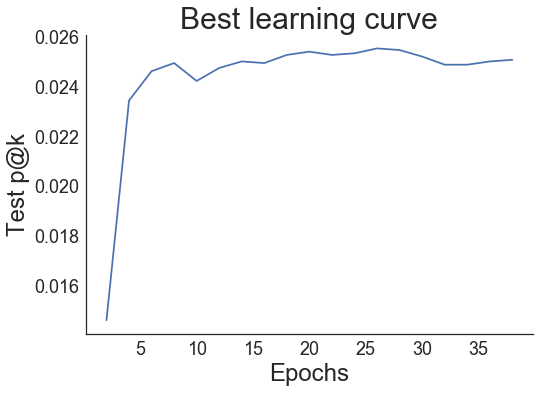

In [25]:
'''
根据top k的精确度最高的模型参数画出学习曲线
'''
import seaborn as sns
sns.set_style('white')
fig, ax = plt.subplots()
sns.despine(fig)
epochs = range(2, 40, 2)
plt.plot(epochs, best_curves[0]['patk']['test'])
plt.xlabel('Epochs', fontsize=24)
plt.ylabel('Test p@k', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Best learning curve', fontsize=30)

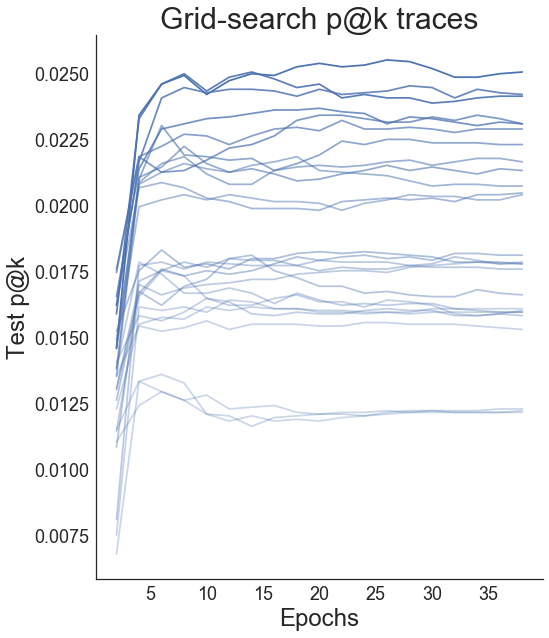

In [27]:
'''
根据所有的参数画出模型的学习曲线
'''
all_test_patks = [x['patk']['test'] for x in best_curves]
fig, ax = plt.subplots(figsize=(8, 10))
sns.despine(fig)
epochs = range(2, 40, 2)
totes = len(all_test_patks)
for i, test_patk in enumerate(all_test_patks):
    ax.plot(epochs, test_patk,
             alpha=1/(.1*i+1),
             c=sns.color_palette()[0])
    
plt.xlabel('Epochs', fontsize=24)
plt.ylabel('Test p@k', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Grid-search p@k traces', fontsize=30)

In [31]:
'''
利用最好的拟合参数训练模型
'''
params = best_curves[0]['params']
params['iterations'] = range(2, 40, 2)[best_curves[0]['patk']['test'].index(max_score)]
print params
'''
{'alpha': 50, 'regularization': 0.0, 'iterations': 26, 'num_factors': 40}
'''
bestALS = ALS(**params)
bestALS.fit(likes)

{'alpha': 50, 'regularization': 0.0, 'iterations': 26, 'num_factors': 40}


In [31]:
item_similarities = bestALS.predict_for_items()